# **Popularitätsprognose von Spotify-Songs** | EMLP-Projekt

[Link zum Datensatz](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks)

## Einleitung
Im Jahr 2020 ist Spotify mit mehr als 60 Millionen gelisteten Musiktiteln und über 320 Millionen aktiven Nutzern der größte Audio-Stremaing-Onlinedienst der Welt [https://www.spotify.com/]. Im Durchschnitt streamt jeder Nutzer pro Tag etwas mehr als eine Stunde Musik [https://de.statista.com/]. Damit ist klar, dass Spotify im Laufe der Zeit einen gigantischen Vorrat an Nutzungsdaten aufbauen konnte. Mit der Anzahl der Wiedergaben und einer Gewichtung, die berücksichtigt, wie lange die Wiedergaben in der Zeit zurückliegen, berechnet Spotify für jeden Track einen Popularity-Index, der auf einer Skala von 0 (unpopulär) bis 100 (populär) angibt, wie beliebt der Track bei den Nutzern ist.  <br>
Über die Web API  [https://developer.spotify.com/documentation/web-api/] können Metadaten, einige Signalanalyse-Parameter, sowie der Popularity-Index der gelisteten Tracks abgerufen werden. Der vorliegenden Datensatz beinhaltet Daten zu mehr als 170 000 Tracks, die über die Web API gesammelt wurden.  <br>
Im Rahmen des EMLP-Projektes soll untersucht werden, welche Faktoren die Popularität eines Tracks beeinflussen. Projektziel ist es, ein Regressions-Modell zu entwickeln, dass die Popularität eines Tracks auf Basis der im Datensatz erfassten Metadaten und Signalanalyse-Parametern möglichst genau vorhersagt. In diesem Projektbericht wird die Umsetzung der Datenanalyse mit Python detailliert beschrieben.

## Bibliotheken und Module

Mit den nachfolgenden Befehlen werden die benötigten Bibliotheken und Module geladen.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

## Erklärung zum Datensatz

Der zu analysierende Datensatz ist wie folgt aufgebaut: Über eine Unique-ID 'id' ist jeder Track eindeutig identifizerbar. Die kategorischen Metadaten 'name' (Songtitel) und 'artist' (Künstler) geben an, um welchen Track es handelt. Das Erscheinungsjahr und das Erscheinungsdatum sind in 'year' und 'release_date' kodiert. Neben dem Popularity-Index 'popularity', der die Beliebtheit des Tracks quantifiziert, enthält der Datensatz weitere numerische Parameter 'valence', 'acousticness', 'dancability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness' und 'tempo', die über Signalanalysealgorithmen berechnet wurden. Diese Parameter charakterisieren die psychoakustischen Eigenschaften der Tracks. Darüber hinaus enthält der Datensatz die binären Daten 'mode' (0: Moll/1: Dur) und 'explicit' (0: jugendfrei/1: nicht jugendfrei) sowie die kategorischen Daten 'key' (Tonart). 
In der nachfolgenden Tabelle sind alle im Datensatz enthaltenen Werte, ihr Datentyp, sowie eine detaillierte Beschreibung aufgelistet.

<table>
  <thead>
    <tr>
      <th>Key</th>
      <th>Value Type</th>
      <th>Value Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>popularity</td>
      <td>int</td>
      <td>Popularity is based on (1) the total number of plays compared to other tracks and (2) how recent those plays are.</td>
    </tr>
    <tr>
      <td>valence</td>
      <td>float</td>
      <td>A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).</td>  
    </tr>
    <tr>
      <td>year</td>
      <td>int</td>
      <td>The release year of track.</td>  
    </tr>
    <tr>
      <td>acousticness</td>
      <td>float</td>
      <td>	A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.</td>  
    </tr>
    <tr>
      <td>artists</td>
      <td>float</td>
      <td>The list of artists credited for production of the track.</td>  
    </tr>
    <tr>
      <td>dancability</td>
      <td>float</td>
      <td>Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.</td>  
    </tr>
    <tr>
      <td>duration_ms</td>
      <td>int</td>
      <td>The duration of the track in milliseconds.</td>  
    </tr>
    <tr>
      <td>energy</td>
      <td>float</td>
      <td>Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.</td>  
    </tr>
    <tr>
      <td>explicit</td>
      <td>int</td>
      <td>The binary value whether the track contains explicit content or not.</td>  
    </tr>
    <tr>
      <td>id</td>
      <td>string</td>
      <td>The Spotify ID for the track.</td>  
    </tr>
    <tr>
      <td>instrumentalness</td>
      <td>float</td>
      <td>Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.</td>  
    </tr>
    <tr>
      <td>key</td>
      <td>int</td>
      <td>The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation as integers in between 0 and 11. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.</td>  
    </tr>
    <tr>
      <td>liveness</td>
      <td>float</td>
      <td>Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.</td>  
    </tr>
    <tr>
      <td>loudness</td>
      <td>float</td>
      <td>The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. </td>  
    </tr>
    <tr>
      <td>mode</td>
      <td>int</td>
      <td>The binary value representing whether the track starts with a major (1) chord progression or not (0).</td>  
    </tr>
    <tr>
      <td>name</td>
      <td>string</td>
      <td>The name of the track.</td>  
    </tr>
    <tr>
      <td>release_date</td>
      <td>string</td>
      <td>The date of release of the track in yyyy-mm-dd, yyyy-mm, or even yyyy format.</td>  
    </tr>
    <tr>
      <td>speachiness</td>
      <td>float</td>
      <td>	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.</td>  
    </tr>
    <tr>
      <td>tempo</td>
      <td>int</td>
      <td>The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.</td>  
    </tr>   
  </tbody>
</table>

## Datenimport

Um die 25 MB Grenze von GitHub zu umgehen, musste die originale CSV-Datei 'data.csv' in zwei Teile gesplittet werden. Hierfür wurde der folgende Code verwendet:

In [1]:
#df = pd.read_csv('data.csv')
#df1 = df[0:85273]
#df2 = df[85273:]
#df1.to_csv("data1.csv", header=list(df1), index=False)
#df2.to_csv("data2.csv", header=list(df2), index=False)

Mit diesen Zeilen werden die gesplitteten Daten importiert und wieder zu einem DataFrame zusammengefügt:

In [2]:
df1 = pd.read_csv('data1.csv') # Einlesen der Daten aus CSV-Datei
df2 = pd.read_csv('data2.csv') # Einlesen der Daten aus CSV-Datei
df = pd.concat([df1,df2], ignore_index = True) # Vertikales Verbinden der beiden DataFrames

## Erste Untersuchung des Datensatzes

In [ ]:
Mit den folgenden Zeilen Code werden grundlegende Informationen zum Datensatz wie zum Beispiel Anzahl der Einträge oder Datentypen untersucht. 

In [3]:
df.info() # Allgemeine Infos zum Datensatz

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [4]:
# df.head() # Die ersten 5 Einträge werden ausgegeben

In [5]:
# df.tail() # Die letzten 5 Einträge werden ausgegeben

In [6]:
# df.describe() # Einige statistische Infos zum Datensatz (Mittelwert, Quantile, ...)

## Bereinigung des Datensatzes

Mit den folgenden Code-Zeilen werden die Werte der Spalte 'duration_ms' in Minuten umgerechnet, was die Verständlichkeit fördert. Tracks mit mehr als 12 min Dauer werden aus dem Datensatz entfernt, da es sich bei diesen mit großer Wahrscheinlichkeit um Hörbücher/Podcasts/Live-Aufnahmen handelt und nicht um Songs. Zudem wird der Datensatz auf Doubletten und 0/NaN-Werte untersucht. Die Spalten 'release_date' und 'id' werden entfernt, da sie keine sinnvollen Informationen beitragen.

In [7]:
df.duration_ms = df.duration_ms/60000 # Umrechnung von ms in min
df = df.rename(columns={'duration_ms' : 'duration_min'}) # Umbenennen der Spalte 'duration_ms' in 'duration_min'
df = pd.DataFrame(df[df['duration_min'] < 12]) # Behalte alle Tracks mit <= 12 min Dauer
#df.head()

In [8]:
n_doubletten = df.duplicated(subset = None, keep = 'first').sum() # Test auf doppelte Einträge
print(f'Der Datensatz enthält {n_doubletten} Doubletten.')

Der Datensatz enthält 0 Doubletten.


In [9]:
n_isnan = df.isnull().sum().sum() # Test auf NaN-Einträge
print(f'Der Datensatz enthält {n_isnan} NaN-Werte.')

Der Datensatz enthält 0 NaN-Werte.


In [10]:
df = df.drop(labels = ['release_date', 'id'], axis = 1) # 'Release_date' ist in unerschiedlicher Genauigkeit angegeben und doppelt sich mit 'year' -> drop!
# 'id' wird ebenfalls gedroppt, da uninformativ

## Split in numerische Daten und String-Daten

Der Datensatz wird für die weiteren Untersuchungen in numerische Daten und String-Daten aufgeteilt.

In [11]:
df_str = pd.DataFrame(data = df, columns = df.columns[df.dtypes == 'object'], index = df.index) # neuer df mit String-Daten
df_num = pd.DataFrame(data = df, columns = df.columns[df.dtypes != 'object'], index = df.index) # neuer df mit numerischen Daten

## Normalisierung der numerischen Daten

Damit in den Machine-Learning-Modellen alle Features mit der selben Gewichtung eingehen, werden die numerischen Daten auf das Intervall [0, 1] normalisiert. 

In [12]:
x = df_num.values # Gibt Daten als NumPy-Array zurück
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x) # [0, 1]-Normalisierung mit Sklearn
df_num = pd.DataFrame(x_scaled, columns = df_num.columns, index = df_num.index)

## Datenvisualisierung

Im Folgenden werden die Daten des Spotify-Datensatzes visualisiert, um erste qualitative Zusammenhänge zu untersuchen.

### Histogramme

In [13]:
# g = df_num.hist(figsize = (15, 15), color = '#1DB954', ec = "black") # Zeigt die Verteilung der Werte; #1DB954 für Spotify-Grün
# plt.suptitle('Histogramme')
# plt.show()

Auffälligkeiten:
- 'valence', 'year' und 'energy' sind in etwa gleichverteilt
- 'dancability', 'duration', 'loudness' und 'tempo' sind ungefähr normalverteilt
- 'acousticness', 'instrumentalness', 'explicit' und 'mode' zeigen eine stark zweiseitige Verteilung
- 'speechiness' ist für fast alle Tracks sehr niedrig

## Pairplot

In [14]:
# plt.figure(figsize = (25, 25))
# g = sns.pairplot(df_num.sample(1000), kind = 'reg', plot_kws = {'line_kws':{'color':'red'}, 'scatter_kws': {'color':'#1DB954','alpha': 0.05}}, diag_kws = {'color':'#1DB954'})
# g.fig.suptitle('Pairplot')
# plt.show()

## Korrelationsmatrix

In [15]:
# plt.figure(figsize = (15, 15))
# ax = plt.axes()
# sns.heatmap(df_num.corr(), annot = True, cmap = 'PiYG', ax = ax)
# ax.set_title('Korrelationskoeffizienten (Pearson)')
# plt.show()

Auffälligkeiten:
- 'year' (r = +0.86), 'energy' (r = +0.48) und 'loudness' (r = +0.46) haben die stärkste positive Korrelation mit der 'popularity'
- 'acousticness (r = -0.57), 'instrumentalness' (r = -0.29) und speechiness (r = -0.17) haben die stärkste negative Korrelation mit der 'popularity'

Fazit: Je aktueller, und energiegeladener (Tempo/Lautstärke/...) ein Track ist, desto populärer ist er. Je größer der Anteil an akustischen Instrumenten oder Sprache (nicht Gesang) ist, desto unpopulärer ist ein Track.

## String-Daten: Target Encoding (Schlechte Idee?)

Die String-Daten 'artist' und 'name' können nicht direkt für das Machine Learning verwendet werden, da es sich nicht um numerische Daten handelt. In diesem Kapitel werden die Daten daher mit einem Target-Encoding in numerische Daten umgewandelt. Die 'artist'-Werte werden mit der mittleren Popularität der Tracks eines Künstlers ('artist_popularity) ersetzt, die 'name'-Strings werden aufgeteilt in einzelne Wörter, für die jeweils die mittlere Popularität berechnet wird. Auf Basis dieser Werte wird ein Titel Popularity-Index für jeden Track zusammengesetzt. <br>
Die Vorgehensweise ist nicht unproblematisch, da durch das Target Encoding die Input- und Target-Daten statistisch voneinander abhängig gemacht werden. 

### Künstler Popularity-Index

In [16]:
df_art = pd.concat([df_str['artists'], df_num['popularity']], axis = 1) # Neuer df mit artist und popularity

In [17]:
df_art['popularity'] = df_art['popularity'].groupby([df_art['artists']]).transform('mean') # Ersetzen der popularity mit mittlerer popularity des artist
df_art = df_art.rename(columns={'popularity' : 'artists_popularity'}) # Umbenennen der Spalte 'popularity' in 'artist_popularity'
df_art = pd.concat([df_art, df_num['popularity']], axis = 1)

In [18]:
df_art.head()

,artists,artists_popularity,popularity
1,['Dennis Day'],0.030000,0.05
2,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.024286,0.05
3,['Frank Parker'],0.030000,0.03
4,['Phil Regan'],0.013333,0.02
5,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.024286,0.06


In [19]:
# plt.figure(figsize=(15, 15))
# g = sns.pairplot(frame.sample(1000), kind = 'reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'color':'#1DB954','alpha': 0.05}}, diag_kws={'color':'#1DB954'})
# g.fig.suptitle('Pairplot')
# plt.show()

In [20]:
df_art.sort_values(by = 'artists_popularity', ascending = False).head(n = 15)

,artists,artists_popularity,popularity
19611,"['Bad Bunny', 'Jhay Cortez']",1.00,1.00
19606,"['24kGoldn', 'iann dior']",0.99,0.99
19608,"['Cardi B', 'Megan Thee Stallion']",0.96,0.96
19620,"['Justin Bieber', 'benny blanco']",0.95,0.95
19720,"['Sech', 'Daddy Yankee', 'J Balvin', 'ROSALÍA'...",0.94,0.94
19655,"['Joel Corry', 'MNEK']",0.94,0.94
19609,"['Drake', 'Lil Durk']",0.93,0.93
19621,['Ritt Momney'],0.93,0.93
19672,"['J Balvin', 'Tainy', 'Dua Lipa', 'Bad Bunny']",0.92,0.92
38452,"['Manuel Turizo', 'Rauw Alejandro', 'Myke Towe...",0.92,0.92


Auffälligkeiten: Kollaborationen pushen die Popularität. "Bad Bunny x Jhay Cortez", "24kGoldn x Iann Dior", "Cardi B x Megan Thee Stallion", "Justin Bieber x Benni Blanco" und "Sech x Daddy Yankee x J Balvin x Rosalía Farruko" sind die 5 populärsten Kollabs. 

### Titel Popularity-Index

In [21]:
df_nam = pd.concat([df_str['name'], df_num['popularity']], axis = 1) # Neuer df mit name und popularity

In [22]:
df_nam['name'] = df_nam.name.astype(str)
df_nam = df_nam.assign(name = df_nam.name.str.split()) # name-String wird anhand von Leerzeichen in Liste getrennt
df_nam['name'] = df_nam['name'].map(lambda a: tuple(a))
df_nam.head()

,name,popularity
1,"(Clancy, Lowered, the, Boom)",0.05
2,"(Gati, Bali)",0.05
3,"(Danny, Boy)",0.03
4,"(When, Irish, Eyes, Are, Smiling)",0.02
5,"(Gati, Mardika)",0.06


In [23]:
df_par = df_nam.explode('name') # Auftrennen des df_nam in einzelne name-Bestandteile und zugehöriger popularity
df_par.head(n=10)

,name,popularity
1,Clancy,0.05
1,Lowered,0.05
1,the,0.05
1,Boom,0.05
2,Gati,0.05
2,Bali,0.05
3,Danny,0.03
3,Boy,0.03
4,When,0.02
4,Irish,0.02


In [24]:
df_par['popularity'] = df_par['popularity'].groupby([df_par['name']]).transform('mean') # Ersetzen der popularity mit mittlerer popularity des name-Bestandteil
df_par = df_par.assign(count = df_par['popularity'].groupby([df_par['name']]).transform('count')) # Zähle Erscheinungen des Namensbestandteils
df_par = df_par.rename(columns={'popularity' : 'name_part_popularity'}) # Umbenennen der Spalte 'popularity' in 'name_part_popularity'
df_par = df_par.drop_duplicates(subset='name')

In [25]:
df_par.sort_values(by = 'name_part_popularity', ascending = False).head(n = 10)

,name,name_part_popularity,count
19611,Dakiti,1.00,1
19608,WAP,0.96,1
19620,benny,0.95,1
19620,blanco),0.95,1
19623,broke,0.95,1
19655,MNEK),0.94,1
19624,Therefore,0.93,1
19672,DIA,0.92,1
19672,(ONE,0.92,1
19672,DAY),0.92,1


Auffälligkeiten: Titel von populären Tracks ("Dakiti") und Namensbestandteile von populären Künstlern "WAP", "Benny", "Blanco"... führen das Ranking der Popularität von Titel-Bestandteilen an. "Broke", "day", "dia" und "popstar" sind ebenfalls prominente Bestandteile. Problem: einzigartige Titel, werden bei dieser Berechnungsmethode überbewertet, da keinerlei statistische Mittelung stattfindet -> Count-Value wird mit einbezogen.

In [26]:
df_par['name_part_popularity'] = 0.6*df_par['name_part_popularity']+0.4*df_par['count']/max(df_par['count']) # Count-Value wird berücksichtigt

In [27]:
df_par.sort_values(by = 'name_part_popularity', ascending = False).head(n = 10)

,name,name_part_popularity,count
19611,Dakiti,0.600013,1
19608,WAP,0.576013,1
19620,blanco),0.570013,1
19623,broke,0.570013,1
19620,benny,0.570013,1
19655,MNEK),0.564013,1
19624,Therefore,0.558013,1
19672,DIA,0.552013,1
19672,DAY),0.552013,1
19672,(ONE,0.552013,1


In [28]:
# Hier wird der Titel-Popularitätsindex berechnet und in ein Excel-File exportiert, dass schnell importiert werden kann (Berechnung dauert ca. 2h!)
#def name_popularity(x, df_nam, df_par):
#    pop = 0
#    n = 0
#    for part in x:
#        pop = pop + df_par['name_part_popularity'][df_par['name'] == part].values
#        n += 1
#    return str(pop/n)   
#
#df_nam['name'] = df_nam['name'].apply(lambda x: name_popularity(x, df_nam, df_par))
#df_nam.to_excel("title_popularity.xlsx")

In [29]:
df_nam = pd.read_excel("title_popularity.xlsx") # vor Re-Import Klammern [ und ] in Excel entfernen!
df_nam = df_nam.rename(columns={'name' : 'title_popularity'})
df_namscaled = df_nam['title_popularity']
x = df_namscaled.values.reshape(-1, 1) # Gibt Daten als NumPy-Array zurück
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x) # [0, 1]-Normalisierung mit Sklearn
df_namscaled = pd.DataFrame(data=x_scaled, index=df_nam.index, columns=['title_popularity'])

In [30]:
df_num = df_num.reset_index(drop=True)
df_namscaled = df_namscaled.reset_index(drop=True)
df_art = df_art.reset_index(drop=True)
df_prepro = pd.concat([df_num, df_namscaled, df_art['artists_popularity']], axis = 1)
df_prepro.head()

,valence,year,acousticness,danceability,duration_min,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,title_popularity,artists_popularity
0,0.9630,0.0,0.734940,0.828947,0.245552,0.341,0.0,0.000000,0.636364,0.160,0.744797,1.0,0.05,0.427835,0.250243,0.279117,0.030000
1,0.0394,0.0,0.964859,0.331984,0.692813,0.166,0.0,0.913000,0.272727,0.101,0.707071,1.0,0.05,0.034948,0.453125,0.042602,0.024286
2,0.1650,0.0,0.970884,0.278340,0.286798,0.309,0.0,0.000028,0.454545,0.381,0.793736,1.0,0.03,0.036495,0.411113,0.321043,0.030000
3,0.2530,0.0,0.960843,0.423077,0.226179,0.193,0.0,0.000002,0.272727,0.229,0.781521,1.0,0.02,0.039175,0.417503,0.326640,0.013333
4,0.1960,0.0,0.581325,0.705466,0.545859,0.346,0.0,0.168000,0.181818,0.130,0.743779,1.0,0.06,0.072165,0.492076,0.040456,0.024286


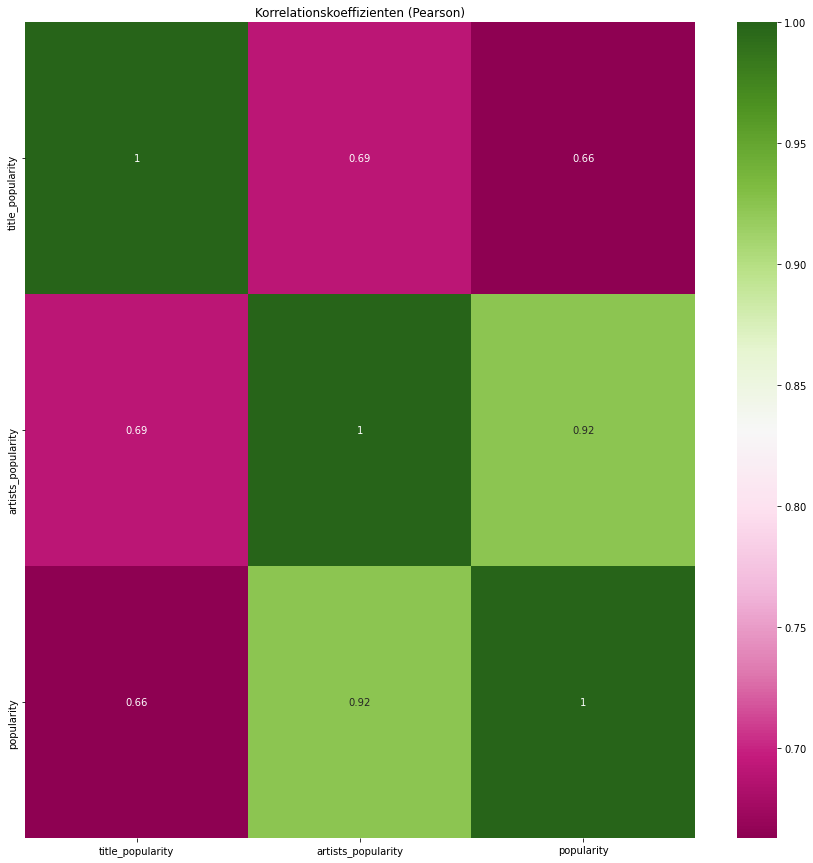

In [31]:
plt.figure(figsize = (15, 15))
ax = plt.axes()
sns.heatmap(df_prepro[['title_popularity', 'artists_popularity', 'popularity']].corr(), annot = True, cmap = 'PiYG', ax = ax)
ax.set_title('Korrelationskoeffizienten (Pearson)')
plt.show()

Auffälligkeiten: Vor allem der 'artists_popularity'-Wert korreliert stark mit der 'popularity', aber auch mit der 'title_popularity' gibt es eine starke Korrelation. Das zeigt, das der Künstler selbst, aber auch der Titel einen Einfluss auf die Popularität eines Tracks haben. Für die nachfolgenden Machine Learning Modelle werden die beiden Werte nicht verwendet, das sie auf Basis der Popularität berechnet wurden und somit die Target-Daten indirekt schon in den Trainingsdaten gegeben wären. 

# Machine Learning Modelle

In [32]:
# Der Datensatz df_prepro enthält nur noch normalisierte numerische Daten, mit denen die Machine Learning Modelle trainiert werden können.